# <font color = 'green'>사이킷런 LinearRegression을 이용한 보스턴 주택 가격 예측

## 1.  피처 탐색


- **CRIME** : 지역별 범죄 발생률
- **ZN** : 25,000평방피트를 초과하는 거주 지역의 비율
- **INDUS** : 비상업 지역 넓이 비율
- **CHAS** : 찰스강에 대한 더미 변
    - 1 : 강의 경계에 위치한 경우
    - 0 : 그 외
    
- **NOX** : 일산화질소 농도
- **RM**  : 거주할 수 있는 방 개수
- **AGE** : 1940년 이전에 건축된 소유 주택의 비율
- **DIS** : 5개 주요 고용센터까지의 가중 거리
- **RAD** : 고속도로 접근 용이도
- **TAX** : 10,000달러당 재산세율
- **PTRATIO** : 지여그이 교사와 학생 수 비율
- **B** : 지역의 흑인 거주 비율
- **LSTAT** : 하위 계층의 비율
- **MEDV** : 본인 소유의 주택 가격(중앙값)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.datasets import load_boston
%matplotlib inline

In [2]:
# 보스턴 데이터 세트 로드
boston = load_boston()

# 보스턴 데이터 세트 DataFrame 변환
bostonDF = pd.DataFrame(boston.data, columns = boston.feature_names)

# 보스턴 데이터 세트의 target 배열은 주택 가격, 이를 PRICE 칼럼으로 DataFrame에 추가
bostonDF['PRICE'] = boston.target
print('Boston 데이터 세트 크기 :',bostonDF.shape)
bostonDF.head()

Boston 데이터 세트 크기 : (506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [3]:
bostonDF.info()
# 데이터 세트 피처의 NULL 값은 없으며 모두 float 형임을 알 수 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  PRICE    506 non-null    float64
dtypes: float64(14)
memory usage: 55.5 KB


## 2. 피처별 중요도 탐색

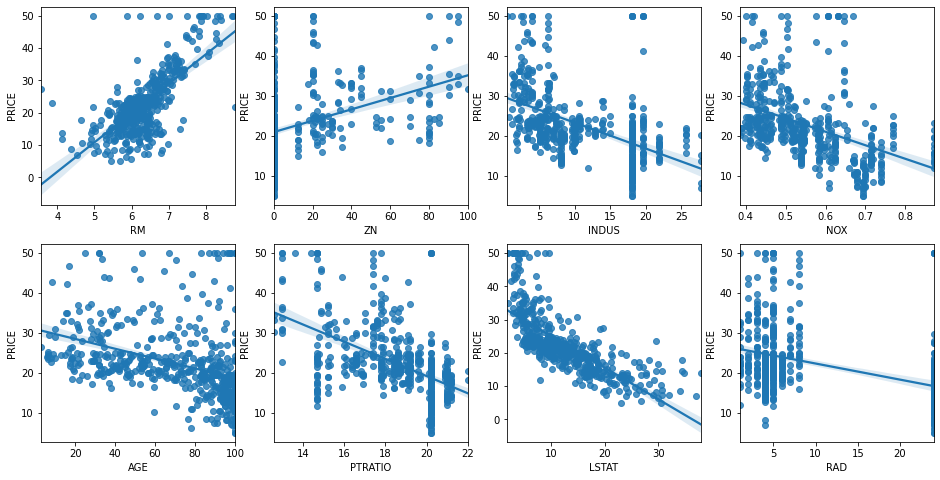

In [4]:
# 8개의 칼럼에 대해 값이 증가할수록 PRICE 값이 어떻게 변하는지 확인
# 시본의 regplot() API는 x,y 축 값의 산점도와 함께 선형 회귀 직선을 그려줌 
# matplotlib.subplots()는 ax마다 칼럼과 PRICE 관계를 함께 표현

# 2개의 행과 4개의 열을 가진 subplots 이용.
# axs는 4x2개의 ax를 가짐
fig, axs = plt.subplots(figsize = (16,8), ncols = 4, nrows = 2)
lm_features = ['RM','ZN','INDUS','NOX','AGE','PTRATIO','LSTAT','RAD']
for i, feature in enumerate(lm_features):
    row = int(i/4)
    col = i%4
    # 시본의 regplot를 이용해 산점도와 선형 회귀 직선을 함께 표현
    sns.regplot(x=feature, y='PRICE',data=bostonDF, ax=axs[row][col])

- **RM(방 개수)** 과 **LSTAT(하위계층의 비율)** 의 PRICE 영향도가 가장 두드러지게 나타남.  
- **RM**은 **양 방향의 선형성**이 가장 크다. 즉 방의 크기가 클수록 가격이 증가하는 모습을 확인할 수 있음.  
- **LSTAT**은 **음 방향의 선형성**이 가장 크다. 즉 LSTAT가 적을수록 PRICE가 증가하는 모습이 확연히 나타남.

## 3. 보스턴 주택 가격의 회귀 모델 생성

### LinearRegression 클래스를 이용한 보스턴 주택 가격의 회귀 모델 생성

In [5]:
from sklearn.model_selection import  train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

y_target = bostonDF['PRICE']
x_data = bostonDF.drop(['PRICE'],axis = 1, inplace=False)

# 학습과 테스트 데이터 세트 분리
x_train, x_test, y_train, y_test = train_test_split(x_data, y_target, test_size=0.3, random_state = 156)

# 선형 회귀 OLS로 학습/예측/평가 수행
lr = LinearRegression()
lr.fit(x_train,y_train)

y_preds = lr.predict(x_test)
mse = mean_squared_error(y_test, y_preds)
rmse = np.sqrt(mse)

print('MSE : {0:.3f}, RMSE : {1:.3f}'.format(mse,rmse))
print('Variance score : {0:.3f}'.format(r2_score(y_test, y_preds)))

MSE : 17.297, RMSE : 4.159
Variance score : 0.757


In [6]:
# 주택 가격 예측 모델의 절편(intercept)과 회귀 계수(coefficients) 값 살펴보기
print('절편 값: ',lr.intercept_)
print('회귀 계수값: ',np.round(lr.coef_,1))

절편 값:  40.995595172164585
회귀 계수값:  [ -0.1   0.1   0.    3.  -19.8   3.4   0.   -1.7   0.4  -0.   -0.9   0.
  -0.6]


In [7]:
# 회귀 계수를 큰 값 순으로 정렬하기 위해 Series로 생성. 인덱스 칼럼명에 유의
coeff = pd.Series(data=np.round(lr.coef_,1),index=x_data.columns)
coeff.sort_values(ascending=False) # 내림차순 정렬

RM          3.4
CHAS        3.0
RAD         0.4
ZN          0.1
INDUS       0.0
AGE         0.0
TAX        -0.0
B           0.0
CRIM       -0.1
LSTAT      -0.6
PTRATIO    -0.9
DIS        -1.7
NOX       -19.8
dtype: float64

### 교차 검증을 이용하여 MSE와 RMSE 측정

In [8]:
from sklearn.model_selection import cross_val_score

y_target = bostonDF['PRICE']
x_data = bostonDF.drop(['PRICE'],axis = 1, inplace = False)
lr = LinearRegression()

# cross_val_score()로 5폴드 세트로 MSE를 구한 뒤 이를 기반으로 다시 RMSE 구함
neg_mse_scores = cross_val_score(lr, x_data, y_target, scoring="neg_mean_squared_error",cv = 5) # 음수로 반환
rmse_scores = np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

# cross_val_score(scoring="neg_mean_squared_error")로 반환된 값은 모두 음수
print('5 folds의 개별 Negative MSE scores : ',np.round(neg_mse_scores,2)) # 음수
print('5 folds의 개별 RMSE scores : ',np.round(rmse_scores,2))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores :  [-12.46 -26.05 -33.07 -80.76 -33.31]
5 folds의 개별 RMSE scores :  [3.53 5.1  5.75 8.99 5.77]
5 folds의 평균 RMSE: 5.829


# <font color = 'green'> 릿지, 라쏘, 엘라스틱넷 회귀 모델 분석
    
## <font color = 'orange'>  릿지 회귀

사이킷런은 Ridge 클래스를 통해 릿지 회귀를 구현한다.  
Ridege 클래스의 주요 생성 파라미터는 alpha이며, 이는 릿지 회귀의 alpha **L2 규제** 계수에 해당한다.

In [9]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score # 예측 성능 평가

# alpha = 10으로 설정해 릿지 회귀 수행
ridge = Ridge(alpha = 10)
neg_mse_scores = cross_val_score(ridge, x_data, y_target, scoring="neg_mean_squared_error",cv=5)
rmse_scores = np.sqrt(-1 * neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 folds의 개별 Negative MSE scores : ',np.round(neg_mse_scores,3)) # 음수
print('5 folds의 개별 RMSE scores : ',np.round(rmse_scores,3))
print('5 folds의 평균 RMSE: {0:.3f}'.format(avg_rmse))

5 folds의 개별 Negative MSE scores :  [-11.422 -24.294 -28.144 -74.599 -28.517]
5 folds의 개별 RMSE scores :  [3.38  4.929 5.305 8.637 5.34 ]
5 folds의 평균 RMSE: 5.518


릿지의 5개 폴드 세트의 **평균 RMSE**는 **5.518**이다.  
규제가 없는 **LinearRegression의 RMSE 평균**인 **5.829**보다 **더 뛰어난 예측성능**을 지니고 있다.


### alpha 값 변화에 따른 5 폴드의 RMSE 평균값 구하기

In [10]:
# 릿지에 사용될 alpha 파라미터 정의
alphas = [0,0.1,1,10,100]

# alpha list 값을 반복하면서 alpha에 따른 평균 rmse 구하기
for alpha in alphas:
    ridge = Ridge(alpha = alpha)
    
    # cross_val_score를 이용해 5 폴드의 평균 RMSE 계산
    neg_mse_scores = cross_val_score(ridge, x_data, y_target, scoring="neg_mean_squared_error",cv=5)
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE : {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때 5 folds의 평균 RMSE : 5.829
alpha 0.1일 때 5 folds의 평균 RMSE : 5.788
alpha 1일 때 5 folds의 평균 RMSE : 5.653
alpha 10일 때 5 folds의 평균 RMSE : 5.518
alpha 100일 때 5 folds의 평균 RMSE : 5.330


alpha가 100일 때 평균 RMSE가 5.332로 가장 좋음

### alpha 값의 변화에 따른 피처의 회귀 계수 값 시각화

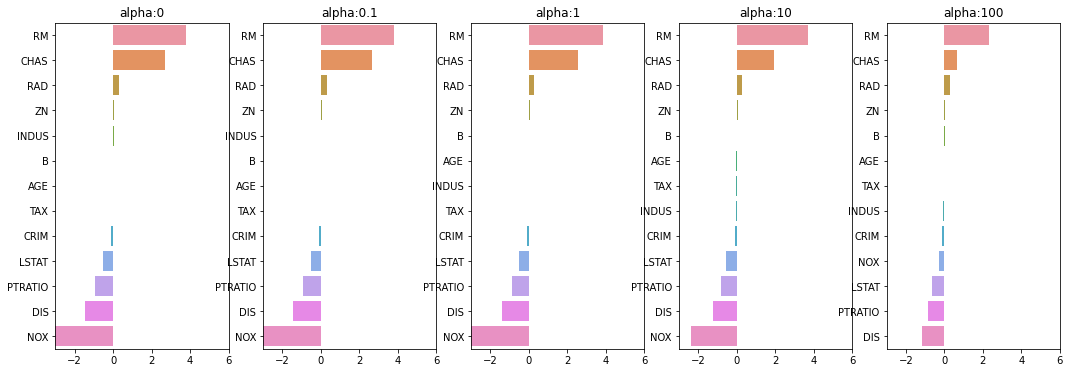

In [11]:
# 시각화를 위한 5개의 열로 된 맷플롯립 축 생성
fig, axs = plt.subplots(figsize = (18,6), nrows = 1, ncols = 5)

# 각 alpha에 따른 회귀 계수 값을 데이터로 저장하기 위한 DataFrame 생성
coeff_df = pd.DataFrame()


# alphas 리스트 값을 차례로 입력해 회귀 계수 값 시각화 및 데이터 저장. pos 는 axis의 위치 지정
for pos, alpha in enumerate(alphas) :
    ridge = Ridge(alpha = alpha)
    ridge.fit(x_data, y_target)
    
    # alpha에 따른  피처별로 회귀 계수를 Series로 변환하고 이를 DataFrame의 칼럼으로 추가
    coeff = pd.Series(data = ridge.coef_, index = x_data.columns)
    colname = 'alpha:'+str(alpha)
    coeff_df[colname] = coeff
    
    # 막대 그래프로 각 alpha 값에서의 회귀 계수를 시각화. 회귀 계수값이 높은 순으로 표현
    coeff = coeff.sort_values(ascending = False)
    axs[pos].set_title(colname)
    axs[pos].set_xlim(-3,6)
    sns.barplot(x = coeff.values, y = coeff.index, ax = axs[pos])
    
# alpha에 따른 피처별 회귀 계수를 DataFrame으로 표시    
plt.show()

alpha 값을 계속 증가시킬수록 회귀 계수 값은 지속적으로 작아짐을 알 수 있다.

In [12]:
ridge_alphas = [0,0.1,1,10,100]
sort_columns = 'alpha:'+str(ridge_alphas[0])
coeff_df.sort_values(by = sort_columns, ascending = False)

,alpha:0,alpha:0.1,alpha:1,alpha:10,alpha:100
RM,3.809865,3.818233,3.854000,3.702272,2.334536
CHAS,2.686734,2.670019,2.552393,1.952021,0.638335
RAD,0.306049,0.303515,0.290142,0.279596,0.315358
ZN,0.046420,0.046572,0.047443,0.049579,0.054496
INDUS,0.020559,0.015999,-0.008805,-0.042962,-0.052826
B,0.009312,0.009368,0.009673,0.010037,0.009393
AGE,0.000692,-0.000269,-0.005415,-0.010707,0.001212
TAX,-0.012335,-0.012421,-0.012912,-0.013993,-0.015856
CRIM,-0.108011,-0.107474,-0.104595,-0.101435,-0.102202
LSTAT,-0.524758,-0.525966,-0.533343,-0.559366,-0.660764


## <font color = 'orange'>라쏘 회귀

사이킷런은 Lasso 클래스를 통해 라쏘 회귀를 구현한다.  
Lasso 클래스의 주요 생성 파라미터는 alpha이며, 이는 라쏘 회귀의 alpha **L1 규제** 계수에 해당한다.

### alpha 값 변화에 따른 RMSE와 각 피처의 회귀 계수

In [13]:
from sklearn.linear_model import * # 모든 회귀 모델 호출

# 수행을 위한 별도의 함수 구현
# 인자로 회귀 모델의 이름, alpha 값들의 리스트, 피처 데이터 세트와 타깃 데이터 세트를 입력 받음
# alpha 값에 따른 폴드 평균 RMSE를 출력하고, 회귀 계수값들을 DataFrame으로 반환

def get_linear_reg_eval(model_name, params=None, x_data_n=None, y_target_n=None, verbose=True, return_coeff=True):
    coeff_df = pd.DataFrame()
    
    if verbose: print('######', model_name, '######')
    for param in params:
        if model_name == 'Ridge': model = Ridge(alpha = param)
        elif model_name == 'Lasso': model = Lasso(alpha = param) 
        elif model_name == 'ElasticNet': model = ElasticNet(alpha = param, l1_ratio = 0.7)
            
        # 교차 검증 수행
        neg_mse_scores = cross_val_score(model, x_data_n, y_target_n, scoring="neg_mean_squared_error",cv=5)
        avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
        print('alpha {0}일 때 5 folds 세트의 평균 RMSE : {1:.3f}'.format(param, avg_rmse))
        
        # cross_val_score는 evaluation metirc만 반환하므로 모델을 다시 학습하여 회귀 계수 추출
        model.fit(x_data_n, y_target_n)
        if return_coeff:
            # alpha 값에  따른 피처별 회귀 계수를 Series로 반환
            # 이후 이를 DataFrame의 칼럼으로 추가
            coeff = pd.Series(data = model.coef_, index = x_data_n.columns)
            colname = 'alpha:'+str(param)
            coeff_df[colname] = coeff
            
    return coeff_df # 각 alpha에 따른 회귀 계수 값을 데이터로 저장한 DataFrame 반환

In [14]:
# alpha 값에 따른 RMSE와 그때의 회귀계수 출력
lasso_alphas = [0.07,0.1,0.5,1,3]
coeff_lasso_df = get_linear_reg_eval('Lasso',params = lasso_alphas, x_data_n = x_data, y_target_n = y_target)

###### Lasso ######
alpha 0.07일 때 5 folds 세트의 평균 RMSE : 5.612
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 5.615
alpha 0.5일 때 5 folds 세트의 평균 RMSE : 5.669
alpha 1일 때 5 folds 세트의 평균 RMSE : 5.776
alpha 3일 때 5 folds 세트의 평균 RMSE : 6.189


In [15]:
# 반환된 DataFrame 확인
coeff_lasso_df

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
RM,3.789725,3.703202,2.498212,0.949811,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
DIS,-1.176583,-1.160538,-0.936605,-0.668790,-0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602


In [16]:
print(lasso_alphas)

[0.07, 0.1, 0.5, 1, 3]


In [17]:
# 반환된 coeff_lassp_df를 첫 번째 칼럼순으로 내림차순 정렬 후 회귀계수 DataFrame 출력
sort_column = 'alpha:'+str(lasso_alphas[0])
coeff_lasso_df.sort_values(by=sort_column, ascending=False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.789725,3.703202,2.498212,0.949811,0.000000
CHAS,1.434343,0.955190,0.000000,0.000000,0.000000
RAD,0.270936,0.274707,0.277451,0.264206,0.061864
ZN,0.049059,0.049211,0.049544,0.049165,0.037231
B,0.010248,0.010249,0.009469,0.008247,0.006510
NOX,-0.000000,-0.000000,-0.000000,-0.000000,0.000000
AGE,-0.011706,-0.010037,0.003604,0.020910,0.042495
TAX,-0.014290,-0.014570,-0.015442,-0.015212,-0.008602
INDUS,-0.042120,-0.036619,-0.005253,-0.000000,-0.000000
CRIM,-0.098193,-0.097894,-0.083289,-0.063437,-0.000000


## <font color = 'orange'>엘라스틱넷 회귀

- 엘라스틱넷 회귀는 **L2 규제와 L1 규제**를 결합한 회귀이다.  
- 서로 상관관계가 높은 피쳐들의 경우에 이들중에서 중요 피처만을 셀렉션하고 다른 피처들은 모두 회귀 계수를 0으로 만드는 성향(라쏘회귀의 특징)이 강하다.
- 알파 값에 따라 회귀 계수의 값이 급격하게 변동하는 것을 막기 위해 **엘라스틱넷 회귀**는 **라쏘회귀에 L2규제를 추가**
- 단점은 수행시간이 상대적으로 오래 걸린다는 것
   

### 회귀 모델 생성

- 사이킷런의 ElasticNet 클래스를 통해 회귀 구현
- 주요 생성 파라미터 
    - alpha : L1 규제의 알파값 a + L2 규제의 알파값 b
    - l1_ratio : (a / (a+b)). 0이면 a가 0이므로 L2규제와 동일. 1이면 b가 0이므로 L1규제와 동일

In [18]:
# 엘라스틱넷에 사용될 alpha 파라미터 값 정의
# 위에서 정의한 get_linear_reg_eval() 함수 호출
# l1_ratio는 0.7로 고정

elastic_alphas = [0.07, 0.1, 0.5, 1, 3]
coeff_elastic_df = get_linear_reg_eval('ElasticNet', params = elastic_alphas, x_data_n = x_data, y_target_n = y_target)

###### ElasticNet ######
alpha 0.07일 때 5 folds 세트의 평균 RMSE : 5.542
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 5.526
alpha 0.5일 때 5 folds 세트의 평균 RMSE : 5.467
alpha 1일 때 5 folds 세트의 평균 RMSE : 5.597
alpha 3일 때 5 folds 세트의 평균 RMSE : 6.068


### alpha 값에 따른 피처별 회귀 계수

In [19]:
# 반환된 ceoff_elastic_df
coeff_elastic_df

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000
RM,3.574162,3.414154,1.918419,0.938789,0.000000
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
DIS,-1.189438,-1.173647,-0.975902,-0.725174,-0.031208
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417


In [20]:
sort_column = 'alpha:'+str(elastic_alphas[0])
coeff_elastic_df.sort_values(by = sort_column, ascending = False)

,alpha:0.07,alpha:0.1,alpha:0.5,alpha:1,alpha:3
RM,3.574162,3.414154,1.918419,0.938789,0.000000
CHAS,1.330724,0.979706,0.000000,0.000000,0.000000
RAD,0.278880,0.283443,0.300761,0.289299,0.146846
ZN,0.050107,0.050617,0.052878,0.052136,0.038268
B,0.010122,0.010067,0.009114,0.008320,0.007020
AGE,-0.010116,-0.008276,0.007760,0.020348,0.043446
TAX,-0.014522,-0.014814,-0.016046,-0.016218,-0.011417
INDUS,-0.044855,-0.042719,-0.023252,-0.000000,-0.000000
CRIM,-0.099468,-0.099213,-0.089070,-0.073577,-0.019058
NOX,-0.175072,-0.000000,-0.000000,-0.000000,-0.000000


alpha 가 0.5일 때 RMSE가 가장 좋은 예측 성능을 보여주고 있음  
alpha값에 따른 피처들의 회귀 계수가 0이 되는 값이 라쏘보다 상대적으로 적음을 알 수 있다.

# <font color = 'green'> 선형 회귀 모델을 위한 데이터 변환

***스케일링/정규화 작업***

- **피처 데이터 세트**
    - StandardScaler / MinMaxScaler 클래스 활용
    - 스케일링/정규화를 수행한 데이터 세트에 다시 다항 특성을 적용하여 변환
    - **로그 변환** -> 제일많이 사용되는 변환 방법
    
    
- **타깃값**
    - **로그 변환**

## 보스턴 주택가격 예측

### 피처 데이터 세트 스케일링/정규화 작업

In [27]:
# 전달 인자 p_degree는 다향식 특성을 추가할 때 적용, p_degree는 2이상 부여하지 않는다.

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
def get_scaled_data(method = 'None', p_degree = None, input_data = None):
  
    # 표준 정규 분포 변환
    if method == 'Standard':
        scaled_data = StandardScaler().fit_transform(input_data)
        
    # 최댓값/최솟값 정규화     
    elif method == 'MinMax':
        scaled_data = MinMaxScaler().fit_transform(input_data)
        
    # 로그변환    
    elif method == 'Log':
        scaled_data = np.log1p(input_data)
        
    else:
        scaled_data = input_data
        
    # 다항식 특성 추가
    if p_degree != None:
        scaled_data = PolynomialFeatures(degree=p_degree, 
                                         include_bias=False).fit_transform(scaled_data)
    return scaled_data

### 릿지 회귀 모델 학습 후 RMSE 확인

In [29]:
# 릿지의 alpha 값을 다르게 적용하고 다양한 데이터 변환 방법에 따른 RMSE 추출
alphas = [0.1, 1, 10, 100]

# 5개 방식으로 변환
# 원본, 표준정규 분포, 표준 정규분포 + 다항식 특성, 최대/최소 정규화, 최대/최수 정규화 + 다항식 분포, 로그변환
scale_methods = [(None, None),('Standard', None),('Standard',2),('MinMax', None),('MinMax',2),('Log',None)]

for scale_method in scale_methods :
    x_data_scaled = get_scaled_data(method = scale_method[0], p_degree = scale_method[1], input_data = x_data)
    
    print ("\n### 변환유형:{0}, Polynomial Degree:{1}".format(scale_method[0], scale_method[1]))
    
    # 릿지 모델 학습 후 alpha값에 따른 RMSE 확인
    get_linear_reg_eval('Ridge',params = alphas, x_data_n = x_data_scaled, y_target_n = y_target, verbose = False, return_coeff = False)


### 변환유형:None, Polynomial Degree:None
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 5.788
alpha 1일 때 5 folds 세트의 평균 RMSE : 5.653
alpha 10일 때 5 folds 세트의 평균 RMSE : 5.518
alpha 100일 때 5 folds 세트의 평균 RMSE : 5.330

### 변환유형:Standard, Polynomial Degree:None
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 5.826
alpha 1일 때 5 folds 세트의 평균 RMSE : 5.803
alpha 10일 때 5 folds 세트의 평균 RMSE : 5.637
alpha 100일 때 5 folds 세트의 평균 RMSE : 5.421

### 변환유형:Standard, Polynomial Degree:2
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 8.827
alpha 1일 때 5 folds 세트의 평균 RMSE : 6.871
alpha 10일 때 5 folds 세트의 평균 RMSE : 5.485
alpha 100일 때 5 folds 세트의 평균 RMSE : 4.634

### 변환유형:MinMax, Polynomial Degree:None
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 5.764
alpha 1일 때 5 folds 세트의 평균 RMSE : 5.465
alpha 10일 때 5 folds 세트의 평균 RMSE : 5.754
alpha 100일 때 5 folds 세트의 평균 RMSE : 7.635

### 변환유형:MinMax, Polynomial Degree:2
alpha 0.1일 때 5 folds 세트의 평균 RMSE : 5.298
alpha 1일 때 5 folds 세트의 평균 RMSE : 4.323
alpha 10일 때 5 folds 세트의 평균 RMSE : 5.185
alpha 100일 때 5 folds 세트의 평균 RMSE : 